### Trabajo No. 1 - Modelado Matemático I
### UNIVERSIDAD INDUSTRIAL DE SANTANDER    
**Profesor: Juan Carlos Basto Pineda - 19 de marzo de 2019**

# PERFILES DE BRILLO Y VELOCIDAD DE GALAXIAS

![GalaxyUrl](https://66.media.tumblr.com/be9c97b9e80c2570d9167a5de6abf53c/tumblr_oi53au6FXh1rx7pfso1_500.gif "galaxy")

El objetivo de este trabajo es explorar el potencial para la manipulación de matrices y análisis de datos
de Python y Numpy, a través de un ejercicio real de investigación relacionado con
la distribución de masa en galaxias espirales.  

**Importante:** A continuación se describe el ejercicio y se proporcionan algunas herramientas fundamentales para permitirle comenzar su trabajo. Se han formulado diferentes preguntas, las cuáles no es obligatorio seguir de forma estrictamente lineal. Su objetivo es darles un punto de partida, pero hay absoluta libertad para explorar los datos en nuevas direcciones, imaginar, discutir, proponer. El límite lo pone cada uno y cada una de ustedes.  

Su trabajo debe ser presentado en uno o más archivos .ipynb en Python 3 y enriquecido con celdas en markdown para mejorar la presentación y la comunicación de la información. Lado a lado con sus archivos estará una carpeta llamada **data/** al interior de la cual se encontrarán todos los archivos .fits con el nombre original con el que son descargados. Asegúrese de usar una estructura idéntica para que su código pueda ser ejecutado en otras máquinas. Comente generosamente sus códigos para que sean comprensibles por otras personas. Gráficos, comentarios y análisis más allá de los mencionados en este documento serán felizmente recibidos.

### 1. Adquisición de los datos
Para cada galaxia a estudiar hay que descargar de la página del [instrumento Fabry-Perot](http://cesam.lam.fr/fabryperot/search/criteria) del 
_Laboratoire d'Astrophysique de Marseille_ los archivos .fits con la imagen y el mapa de velocidades.
La imagen es el archivo llamado xdss. En cuanto a los mapas de velocidad, hay 2 versiones. Comience analizando una sola galaxia, y por ahora use el mapa llamado sólamente _velocity field_ (\*\*\*\_rv\_voro.fits). El _velocity field bin_ (\*\*\*\_rv\_bin.fits) lo dejaremos para más adelante.



In [1]:
# Importamos las bibliotecas necesarias
import astropy.io.fits as fits 
import numpy as np
import matplotlib.pyplot as plt

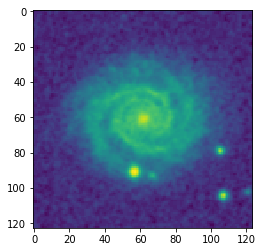

In [5]:
# Leer y visualizar los datos de brillo superficial
hdu = fits.open("data/ugc4555_dss.fits")
flux = hdu[0].data
plt.imshow(np.log10(flux),interpolation=None)

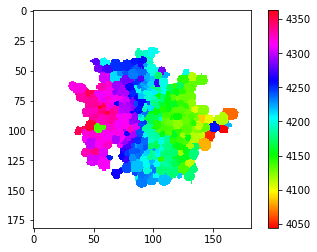

In [6]:
# Equivalentemente con el mapa de velocidad
hdu = fits.open("data/ugc4555_rv_voro.fits")
velmap = hdu[0].data
plt.imshow(velmap,cmap="hsv",interpolation=None)
plt.colorbar()

### 2. Deproyección de los mapas
Como se explicó en clase, las galaxias tipo disco son circulares en primera aproximación,
y solo aparecen como elipses en el plano del cielo por que están inclinadas.
Por esto, las coordenadas polares $(R,\psi)$ de un pixel en la geometría proyectada, corresponden
en realidad a una pareja de coordenadas diferente $(r,\theta)$ en el disco galáctico.
Este último radio, $r$, es el verdadero radio físico en el disco, y es el que necesitamos para construir los perfiles de brillo y velocidad. 

\begin{eqnarray}
\alpha & = & \sqrt{\cos(\psi)^2 + \frac{\sin(\psi)^2}{\cos(i)^2}} \nonumber \\
r & = & \alpha R \nonumber
\end{eqnarray}

Por otro lado, necesitamos transformar cada velocidad medida por efecto Doppler a lo largo de la línea de visión, $V_{los}$ , en la correspondiente velocidad de rotación. Asumiendo que el disco
está en rotación pura:


\begin{eqnarray}
V_{circ}(r) & = & (V_{los}(R) - V_{sys})\frac{\alpha}{\sin(i)\cos(\psi - \psi_0)} \nonumber
\end{eqnarray}

En la última ecuación el término $\psi - \psi_0$ está para recordarle que los ángulos se miden
respecto al semieje mayor de la galaxia, el cual no siempre está alineado horizontalmente. La orientación de dicho semieje (_position angle_) desde un punto de vista dinámico ya ha sido analizada [(Epinat, 2010)](http://adsabs.harvard.edu/abs/2008MNRAS.390..466E), al igual que la inclinación y la velocidad sistémica. Estos datos pueden ser consultados en la misma página donde se descargaron los archivos .fits.  

**Notas:** Por ahora las distancias $R,r$ pueden ser manejadas en pixeles. Tenga cuidado con la definición del ángulo de posición en la página, asegúrese de estar midiendo este ángulo desde el mismo punto de referencia asumido allí.

### Test:
Para una galaxia de prueba, construya las matrices de $R,r,\psi$ y visualízelas con `plt.imshow`. ¿Lucen como deberían? Repita el ejercicio con otra galaxia diferente a UGC4555, una en la cual el semieje mayor no esté alineado horizontalmente, y verifique la integridad de sus resultados.


In [8]:
# En este ejemplo se ilustra la creación de los arrays R,Psi,
# para analizar una imagen hipotética de 100 x 100 pixeles.
# Asegúrese de entender el significado de cada línea muy bien

# creamos los vectores con las coordenadas x,y
x = np.arange(100)
y = np.arange(100)
# Array de coordenadas x,y, un elemento por cada pixel en la imagen
yy,xx = np.meshgrid(x,y)
# definimos la posición central del array en pixels
xc,yc = 49.5,49.5
# Usamos las definiciones para R,Psi
R = np.sqrt((xx-xc)**2 + (yy-yc)**2)
Psi = np.arctan((yy-yc)/(xx-xc))
# En la siguiente línea convertimos radianes a grados
# para facilitar la interpretación del resultado
# ATENCIÓN: las sumas establecen un rango de 0 a 360 grados,
# PERO la posición del 0 pueden no corresponder a la misma
# convención utilizada para reportar los position angle
Psi = np.rad2deg(Psi) + 90
Psi[50:,:] = Psi[50:,:]+180

# Visualice las matrices R,Psi. Son lo que esperaba?
# Construya los arrays alpha,r a partir de R,Psi.
# Deproyecte el mapa de velocidades observado, V_los,
# para obtener el mapa de velocidades circulares, V_circ

### 3. Exploración de los perfiles unidimensionales
El siguiente paso es extraer los perfiles radiales de brillo y velocidad circular.

En primer lugar vamos a crear un gráfico unidimensional de $Brillo\, Vs.\, radio$ para todos los pixeles individuales. Use una escala logarítmica para el brillo. En segundo lugar obtenga un gráfico unidimensional de $V_{circ}\, Vs.\, radio$ para todos los pixeles individuales. Esto ya nos mostrará la forma de los perfiles radiales, aunque se espera una dispersión considerable en los datos.

### 4. Creación de los perfiles unidimensionales

Para crear el verdadero perfil de brillo, clasificaremos los pixeles en intervalos (bins) radiales, por ejemplo de 5 en 5 pixeles, y promediaremos la luz de todos los pixeles en cada intervalo. Esta medida es representativa del brillo superficial a esa distancia del centro, en unidades de Flujo/pixeles$^2$. El radio a reportar de cada bin será el promedio los valores de $r$ de los pixeles considerados. Promedie los flujos luminosos como fueron medidos, la escala logarítmica se utiliza sólamente al momento de graficar.

Para el perfil radial de las velocidades circulares hacemos exactamente lo mismo, esta vez promediando $V_{circ}$. Así podremos construir nuestra curva de rotación $V_{circ}\, Vs.\, radio$.

Verifique que cada uno de los puntos obtenidos en sus perfiles radiales provenga de la media de al menos 5 datos en los mapas. De lo contrario, ajuste el ancho de los bins que sea necesario para garantizar esto.

### 5. Resultados

El resultado mínimo de su trabajo deben ser los perfiles mencionados para al menos una galaxia, y presentarlos gráficamente.
Sin embargo, a continuación se sugieren múltiples puntos para invitale a seguir investigando y desarrollando sus destrezas con python, numpy y matplotlib.

### 6. Desafíos

* Sería interesante además de mostrar una imagen, almacenarlas. Cree una carpeta llamada images y pida a su código almacenar sus gráficos allí con un nombre significativo, p.ej: (ugc4555\_vcir.jpg)

* También sería múy útil conservar la información de los perfiles para un estudio posterior. Pruebe a guardar los perfiles obtenidos en forma de tablas en la carpeta **data/**, por ejemplo con los nombres (ugc4555\_sbp.txt), (ugc4555\_vcir.txt)

* Reportar los radios en pixeles no es muy significativo, así que pasaremos las distancias a unidades angulares en el cielo. La equivalencia de un pixel en arcos de segundo (arcsec) para cada imagen está dada en el header de los datos. Debajo se muestra un ejemplo de cómo desplegar el header y cómo acceder directamente a los valores en él. Use los radios en arcsec en sus imágenes y tablas.

```python
hdu = fits.open("data/ugc4555_rv_voro.fits")
velmap = hdu[0].data
header = hdu[0].header
print(header)
scale_x = header["CDELT1"]
scale_y = header["CDELT2"]
```

* Cualquier medida tiene una incertidumbre asociada, y nuestros datos no son la excepción. Tras deproyectar las velocidades y promediar $V_{circ}$ en cada bin radial, determine la desviación estándar de esas medidas y úsela para agregar una barra de error a su curva de rotación. Incluya esta incertidumbre como una tercera columna a la tabla.

* Escriba su código de tal forma que el estudio propuesto sea fácilmente reproducible para otras galaxias. Algunos ejemplos de galaxias en rotación son UGC: 10470, 10075, 11218, 11914, 4256, 4555, 5510, 5842, 8334, 9866. Para obtener los datos de estas y muchas más del mismo proyecto rápidamente, en los criterios de búsqueda escoja survey -> GHASP.

* Posiblemente haya percibido que existen unos puntos con luminosidades extrañamente altas para la posición en que se encuentran, claramente visibles formando círculos en la imagen. Se trata de estrellas de _"foreground"_, es decir, estrellas de nuestra propia galaxia que están en dirección a la galaxia observada y no se pueden evitar. Piense cómo podríamos eliminar la influencia inapropiada de estos puntos en el perfil de brillo y trate de implementar una solución.

* Algunas veces al deproyectar las velocidades resultan puntos singulares con velocidades extremadamente altas. Esto en general no es real y se debe a que en la ecuación de deproyección estamos dividiendo por $cos(\psi-\psi_0)$, que en algunos casos puede ser muy cercano a 0, haciendo que un error pequeño en la medición sea enormemente amplificado. Piense cómo podríamos eliminar la influencia inapropiada de estos puntos en la curva de rotación, y trate de implementar una solución.










## Desafío final

El objetivo final de este tipo de análisis es inferir el contenido de materia oscura en las galaxias de tipo disco. Para hacer un primer test al respecto, vamos a suponer que el perfil de brillo traza el perfil de masa en el disco estelar, que es dinámicamente la componente visible más importante, y vamos a comparar las velocidades circulares esperadas en el potencial gravitacional del disco solo, con las velocidades circulares efectivamente observadas. Si usted encuentra algo como lo observado en la siguiente figura, **!Felicitaciones!**, hemos encontrado evidencia de materia oscura en el Universo :)

![SegmentLocal](M33_rotation_curve_HI.gif "segment")

Ajuste **a ojo** o con una rutina de mínimos cuadrados una línea recta a su perfil de brillo en escala logarítmica, esta vez usando logaritmo natural (es decir $\ln(Brillo)\, Vs. r$). Esto se hace por que se ha observado que el perfil de brillo en la mayoría de galaxias tipo disco sigue una ley exponencial. Si el perfil se desvía mucho de una línea recta, de prelación a los radios intermedios, es decir, excluya el centro y la región externa del disco en el ajuste. 

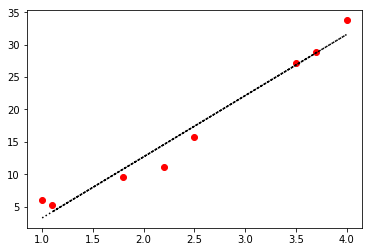

In [2]:
# Ejemplo de ajuste de una línea recta por
# mínimos cuadrados utilizando una rutina
# tipo Levenberg-Marquadt

from scipy.optimize import leastsq

x=np.array([1.0,2.5,3.5,4.0,1.1,1.8,2.2,3.7])
y=np.array([6.008,15.722,27.130,33.772,5.257,9.549,11.098,28.828])

# Modelo que deseo ajustar, en este caso una recta
def funcLine(params,x):
    return params[0]*x+params[1]

# Función de error (lo que se va a querer
# minimizar es la suma de errores cuadráticos)
def ErrorFunc(tpl,x,y):
    return funcLine(tpl,x)-y

# Valor inicial, punto de partida para el algoritmo
p0 = [10,-6]

# La función leastsq itera desde el valor inicial,
# buscando minimizar el error cuadrático
# best_params serán los parámetros del mejor modelo
best_params,success = leastsq(ErrorFunc,p0,args=(x,y))
y2 = funcLine(best_params,x)
plt.plot(x,y,"or")
plt.plot(x,y2,":k")

Sea la recta ajustada $\ln(Brillo) = -\frac{r}{h} + B_0$. El parámetro $h$ se conoce como el _scale length_ del disco, y es el radio al cual el brillo superficial ha caído en un factor $1/e$. Suponiendo que el disco no tiene espesor, es posible mostrar que la velocidad circular de una partícula test en el campo gravitacional de este disco es proporcional a 

$$V_{disk}^2 \propto  h y^2 \left[I_0(y)K_0(y) - I_1(y)K_1(y)\right]$$ 

donde $y=\frac{r}{h}$, y las funciones $I_0, K_0,I_1, K_1 $ son las funciones especiales de Bessel de primer y segundo orden, disponibles en el módulo `scipy.special`.

Utilizando un valor arbitrario para la constante de proporcionalidad genere la curva de rotación debida al disco de estrellas, y luego escálela para grafícarla junto a la curva de rotación obtenida del mapa, amplificándola al máximo permitido por la curva observada (es decir, sin ultrapasarla).

* ¿Qué observa?
* ¿Es la masa en forma de estrellas suficiente para explicar las velocidades de giro observadas?
* En caso de discrepancia, ¿esta ocurre en el centro de las galaxias o en la región exterior?
* ¿Pasa lo mismo en todas las galaxias? 
* ¿Este análisis sugiere la existencia de materia oscura en galaxias espirales?
* ¿Abundantemente o solo un poco?

## ¡Buen trabajo!
![ChessUrl](https://i.pinimg.com/originals/44/bf/8b/44bf8b5a11f4cedff5c1c2778b0f7b9c.gif "chess")